# TP 3 - Probabilité d'exécution sur les marchés cryptos centralisés

Vous utiliserez une semaine de données L1 (prix/volume aux premières limites et transactions) sur les marchés centralisés (CEXs) Bitstamp, Kraken et Binance US et les paires BTC-USD et ETH-USD.

Installer `pyarrow` puis charger les données dans un `DataFrame` `pandas` en utilisant l'exemple suivant.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.stats import kurtosis, skew

Conversion des timestamps des index au format `datetime` de `pandas`.

In [2]:
exchanges = ['binanceus', 'bitstamp', 'kraken']
coins = ['btcusd', 'ethusd']

dict_l1 = {}
dict_trades = {}

for exchange in exchanges:
    for coin in coins:
        
        df_l1 = pd.read_parquet(
            f"../Crypto Data/l1_{coin}_{exchange}.parquet",
            engine="pyarrow"
        )

        df_trades = pd.read_parquet(
            f"../Crypto Data/trades_{coin}_{exchange}.parquet",
            engine="pyarrow"
        )
        df_l1['imbalance'] = (df_l1['best_bid_qty'] - df_l1['best_ask_qty'])/(df_l1['best_bid_qty'] + df_l1['best_ask_qty'])
        df_l1['log_imbalance'] = np.log(df_l1['best_bid_qty']/df_l1['best_ask_qty'])
        df_l1['date'] = [datetime.fromtimestamp(t) for t in df_l1.index]
        df_trades['date'] = [datetime.fromtimestamp(t) for t in df_trades.index]
        dict_l1[f'{coin}_{exchange}'] = df_l1
        dict_trades[f'{coin}_{exchange}'] = df_trades


Dans les données L1, vous avez 4 colonnes avec les prix des bests bid et ask ainsi que les quantités disponibles.

In [3]:
dict_l1['btcusd_binanceus'].head()

,best_bid_price,best_ask_price,best_bid_qty,best_ask_qty,imbalance,log_imbalance,date
1.675210e+09,23127.29,23129.59,0.009625,0.059662,-0.72217,-1.824331,2023-02-01 01:00:00.014691
1.675210e+09,23127.29,23129.59,0.009625,0.059662,-0.72217,-1.824331,2023-02-01 01:00:00.014967
1.675210e+09,23127.29,23129.59,0.009625,0.059662,-0.72217,-1.824331,2023-02-01 01:00:00.014969
1.675210e+09,23127.29,23129.59,0.009625,0.059662,-0.72217,-1.824331,2023-02-01 01:00:00.014970
1.675210e+09,23127.29,23129.59,0.009625,0.059662,-0.72217,-1.824331,2023-02-01 01:00:00.014971


Dans les données des transactions, vous disposez des prix, des quantités et du côté (Bid/Ask) des transactions.

In [4]:
dict_trades['btcusd_binanceus'].head()

,price,size,maker_side,date
1.675210e+09,23127.29,0.009625,B,2023-02-01 00:59:59.967
1.675210e+09,23127.11,0.043339,B,2023-02-01 00:59:59.967
1.675210e+09,23127.08,0.011344,B,2023-02-01 00:59:59.967
1.675210e+09,23127.07,0.011216,B,2023-02-01 00:59:59.967
1.675210e+09,23127.05,0.011244,B,2023-02-01 00:59:59.967


## 1. Microstructure du processus de rendements

##### Pour les horizons 1 seconde et 1 minute:

Calculer les séries de rendement du mid price pour les différentes paires (à horizon $h$ égal à 1 minute et 1 seconde) et faire un histogramme de la distribution pour chaque horizon $h$. Pour chaque $h$, calculer le kurtosis et le skewness, puis calculer la fonction de survie du rendement absolu $S$ définie par

$$S(r):=\mathbb{P}(|R|>r).$$

In [5]:
def returns_process(time, coin, venue):

    df_l1 = dict_l1[f'{coin}_{venue}'].copy()
    df_l1 = df_l1.set_index("date")
    df_l1['timestamp'] = df_l1.index
    df_l1['mid_price'] = (df_l1.best_bid_price + df_l1.best_bid_price) / 2

    returns = (df_l1.mid_price.resample(time).last().values - df_l1.mid_price.resample(time).first().values) / df_l1.mid_price.resample(time).first().values
    returns = returns[~np.isnan(returns)]
    abs_returns = np.abs(returns)
    nb_returns = len(abs_returns)
    survival_func_values = np.zeros(100)
    r_values = np.linspace(0, np.max(abs_returns), 100)
    for (i, r) in enumerate(r_values):
        survival = len(abs_returns[abs_returns >= r])/nb_returns
        survival_func_values[i] = survival

    return returns, abs_returns, r_values, survival_func_values

- Pour $h = 1$ seconde et binance US sur le BTC/USD : 

In [6]:
returns, abs_returns, r_values, survial_func_values_1s_binance = returns_process("1s","btcusd", "binanceus")

On trace alors l'histogramme des rendements pour observer leur distribution.

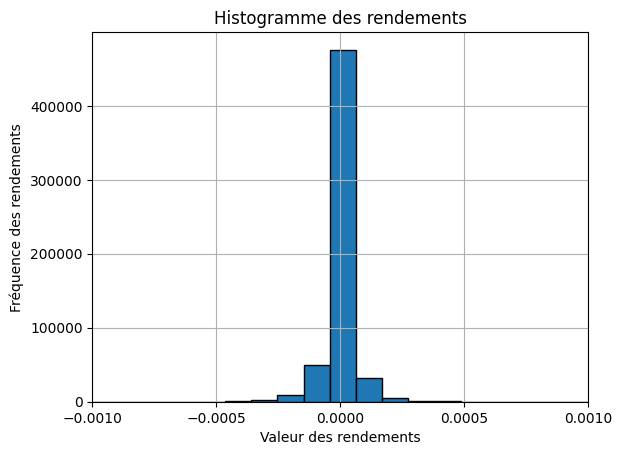

In [7]:
plt.hist(returns, bins=40, edgecolor='black')
plt.xlabel('Valeur des rendements')
plt.ylabel('Fréquence des rendements')
plt.title('Histogramme des rendements')
plt.xlim(-0.001, 0.001)
plt.xticks(np.arange(-0.001, 0.0015, 0.0005))
plt.grid(True)
plt.show()

De même, on calcule le kurtosis et le skewness :

In [8]:
kurt = kurtosis(returns)
skewness = skew(returns)

print(f"Le kurtosis vaut {np.round(kurt, 2)} et le skewness vaut {np.round(skewness, 2)}.")

Le kurtosis vaut 48.96 et le skewness vaut -0.61.


Ainsi que la fonction de survie pour les venues :

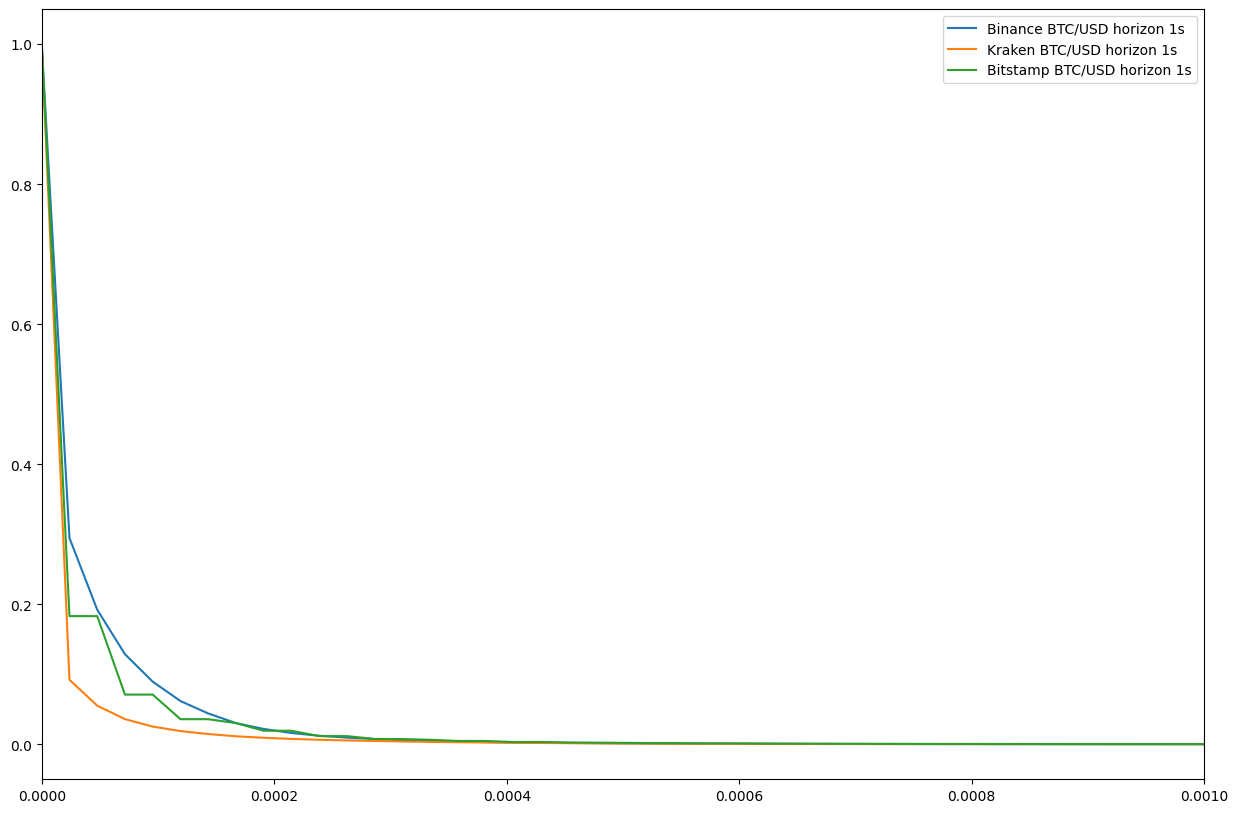

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlim(0, 0.001) 

_, _, _, survial_func_values_1s_kraken = returns_process("1s", "btcusd", "kraken")
_, _, _, survial_func_values_1s_bitstamp = returns_process("1s", "btcusd", "bitstamp")

ax.plot(r_values, survial_func_values_1s_binance, label = "Binance BTC/USD horizon 1s")
ax.plot(r_values, survial_func_values_1s_kraken, label = "Kraken BTC/USD horizon 1s")
ax.plot(r_values, survial_func_values_1s_bitstamp, label = "Bitstamp BTC/USD horizon 1s")

plt.legend();

- Pour $h = 1$ minute et binance US sur le BTC/USD : 

In [10]:
returns, abs_returns, r_values, survial_func_values_1min_binance = returns_process("1min","btcusd", "binanceus")

On trace alors l'histogramme des rendements pour observer leur distribution.

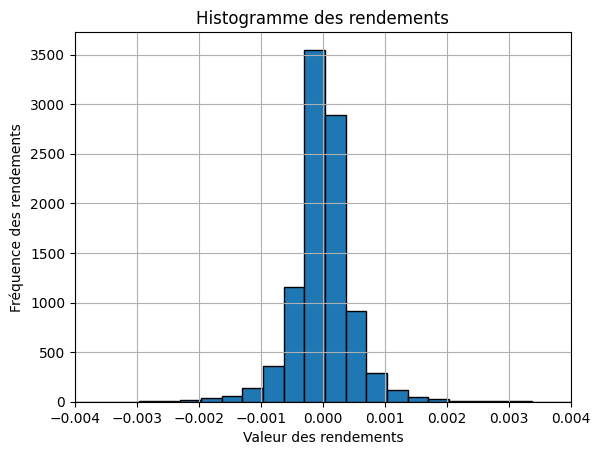

In [11]:
plt.hist(returns, bins=40, edgecolor='black')
plt.xlabel('Valeur des rendements')
plt.ylabel('Fréquence des rendements')
plt.title('Histogramme des rendements')
plt.xlim(-0.004, 0.004)
plt.xticks(np.arange(-0.004, 0.0045, 0.001))
plt.grid(True)
plt.show()

De même, on calcule le kurtosis et le skewness :

In [12]:
kurt = kurtosis(returns)
skewness = skew(returns)

print(f"Le kurtosis vaut {np.round(kurt, 2)} et le skewness vaut {np.round(skewness, 2)}.")

Le kurtosis vaut 19.84 et le skewness vaut -0.31.


Ainsi que la fonction de survie pour les venues :

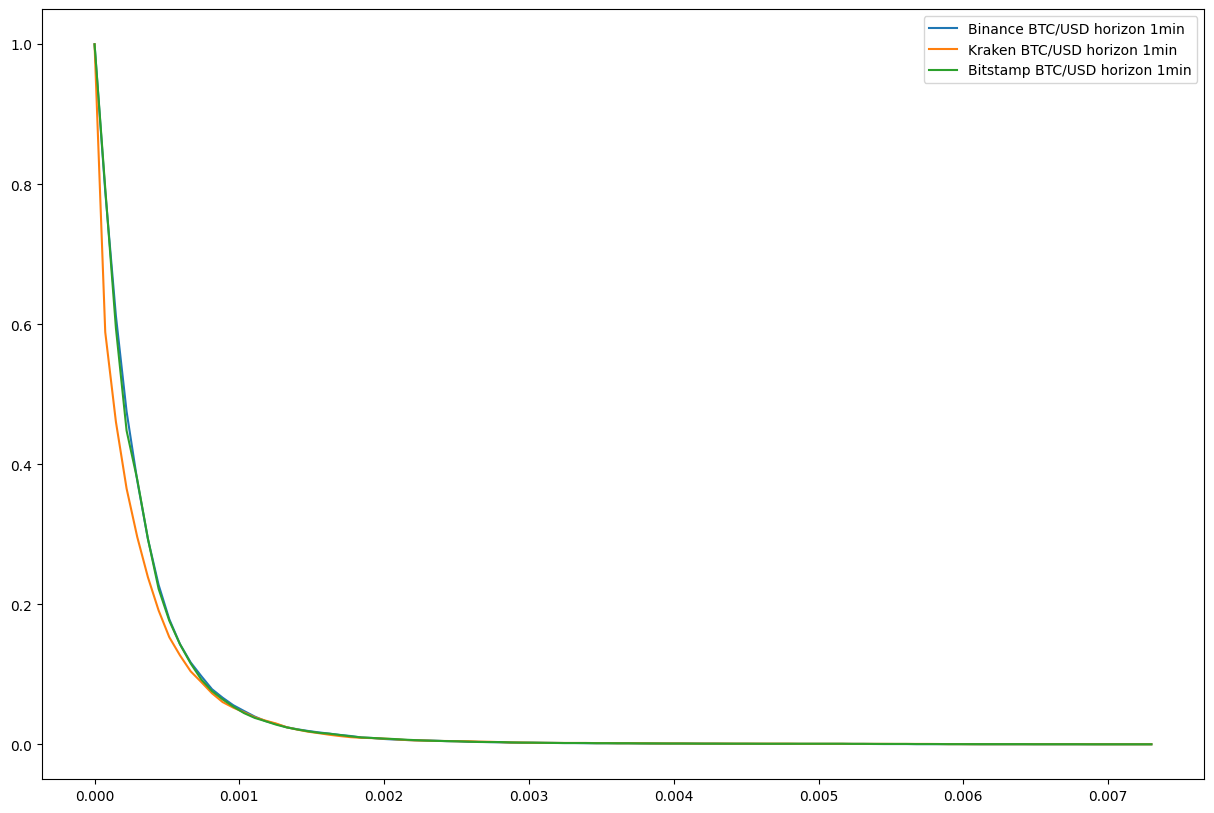

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
_, _, _, survial_func_values_1min_kraken = returns_process("1min","btcusd", "kraken")
_, _, _, survial_func_values_1min_bitstamp = returns_process("1min","btcusd", "bitstamp")

ax.plot(r_values, survial_func_values_1min_binance, label = "Binance BTC/USD horizon 1min")
ax.plot(r_values, survial_func_values_1min_kraken, label = "Kraken BTC/USD horizon 1min")
ax.plot(r_values, survial_func_values_1min_bitstamp, label = "Bitstamp BTC/USD horizon 1min")

plt.legend();

Faire un plot de $S$ en échelle log-log pour chaque horizon $h$ et conclure. Les propriétés sont-elles similaires d'une bourse à une autre ?

Traçons cette fois-ci la fonction de survie en échelle log-log :

- Pour l'horizon $h = 1$ seconde :

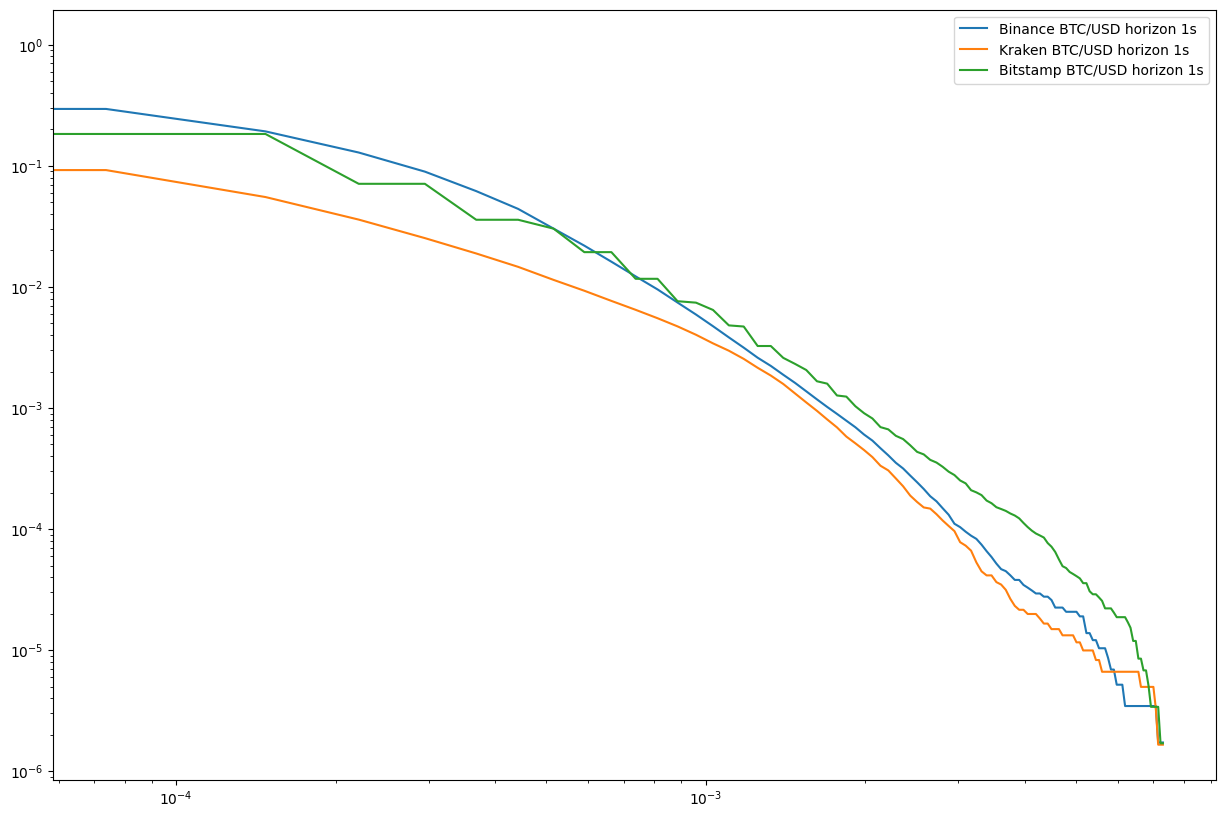

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.loglog(r_values, survial_func_values_1s_binance, label = "Binance BTC/USD horizon 1s")
ax.loglog(r_values, survial_func_values_1s_kraken, label = "Kraken BTC/USD horizon 1s")
ax.loglog(r_values, survial_func_values_1s_bitstamp, label = "Bitstamp BTC/USD horizon 1s")

plt.legend();

- Pour l'horizon $h = 1$ minute :

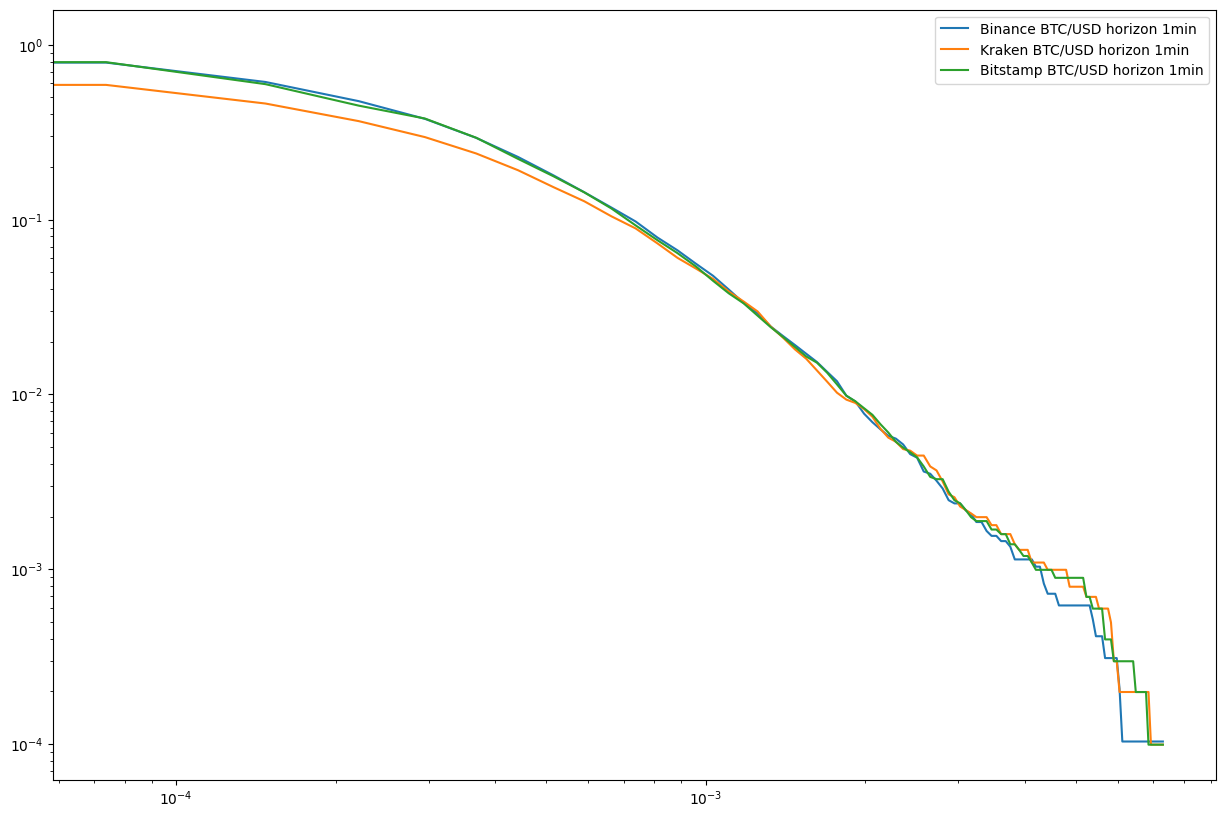

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.loglog(r_values, survial_func_values_1min_binance, label = "Binance BTC/USD horizon 1min")
ax.loglog(r_values, survial_func_values_1min_kraken, label = "Kraken BTC/USD horizon 1min")
ax.loglog(r_values, survial_func_values_1min_bitstamp, label = "Bitstamp BTC/USD horizon 1min")

plt.legend();

On observe que les résultats ne semblent pas dépendre de la bourse et que les propriétés sont similaires en ce qui concerne les returns à horizons $1$ seconde et $1$ minute.

## 2. Calcul des probabilités d'exécution

### Préliminaire. Calcul de la taille du tick

Caluler la taille du tick de toutes les paires sur les trois marchés. On les stockera dans un dictionnaire pour pouvoir y accéder facilement.

In [16]:
dict_tick_size = {}

for exchange in exchanges:
    for coin in coins:

        diff = dict_l1[f'{coin}_{exchange}'].best_bid_price.diff().to_numpy()
        tick = np.around(np.min(diff[diff > 0]), 2)
        dict_tick_size[f'{coin}_{exchange}'] = tick

dict_tick_size

{'btcusd_binanceus': 0.01,
 'ethusd_binanceus': 0.01,
 'btcusd_bitstamp': 1.0,
 'ethusd_bitstamp': 0.1,
 'btcusd_kraken': 0.1,
 'ethusd_kraken': 0.01}

### a. Etude de la sensibilité selon la distance de placement

Considérons un agent qui place un ordre limite de taille infinitésimale à une distance $\delta\geq0$ ticks du BBO (Best Bid Offer). L'objectif de cette partie est d'étudier la probabilité $p(\delta)$ que l'ordre soit exécuté sous un horizon fixé $h$. On fixera $h$ égal à 10 secondes dans cette partie seulement.

Dans un premier temps, développer une méthode de calcul de cette probabilité pour une distance $\delta=0$ en réalisant un sampling des snapshots des carnets.

Par exemple: si on se place au bid, on peut échantillonner un carnet toutes les secondes puis placer un ordre "artificiel" à un prix $P_{bid}$ situé à une distance $\delta$ du best bid, puis considérer l'ordre comme exécuté à partir du moment où une transaction a eu lieu à un prix inférieur à $P_{bid}$. Enregistrer la valeur $X_i^\delta=1$ si l'ordre est exécuté, la valeur $X_i^\delta=0$ s'il ne l'est pas, puis calculer l'estimateur empirique sur l'ensemble des ordres:

$$\widehat{p(\delta)}=\frac{1}{N}\sum_{i=1}^NX_i^\delta.$$

In [17]:
def compute_proba_fill(delta: float=0, 
                       N: int=int(1e3), 
                       h: float=10, 
                       duration: int=100, 
                       venue: str='binanceus', 
                       coin: str='btcusd') -> float:
    
    somme = 0
    df_l1 = dict_l1[coin + '_' + venue]
    df_trades = dict_trades[coin + '_' + venue]

    for i in range(N):
        
        price = df_l1.iloc[duration*i].best_bid_price - delta
        ts = df_l1.iloc[duration*i].name

        if (df_trades[(df_trades.index > ts) & (df_trades.index <= ts + h)]['price'] < price).any():

            somme += 1

    return somme / N

Dans un second temps, faire varier la distance $\delta$ de placement pour obtenir une courbe de probabilité d'exécution. Avec quelle classe de fonction paramétrique modéliseriez-vous la fonction $p(\delta)$ ?

In [18]:
nb_deltas = 20

deltas_binance = dict_tick_size['btcusd_binanceus']*np.arange(0, nb_deltas)
probas_fill_binance = np.zeros(nb_deltas)

for (i, delta) in enumerate(deltas_binance):

    probas_fill_binance[i] = compute_proba_fill(delta=delta)

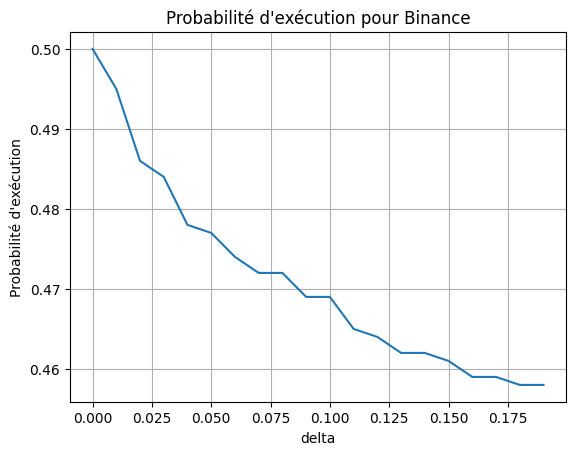

In [19]:
plt.plot(deltas_binance, probas_fill_binance)
plt.xlabel('delta')
plt.ylabel("Probabilité d'exécution")
plt.title("Probabilité d'exécution pour Binance")
plt.grid(True)
plt.show()

In [20]:
nb_deltas = 20

deltas_kraken = dict_tick_size['btcusd_kraken']*np.arange(0, nb_deltas)
probas_fill_kraken = np.zeros(nb_deltas)

for (i, delta) in enumerate(deltas_kraken):

    probas_fill_kraken[i] = compute_proba_fill(delta=delta, venue='kraken')

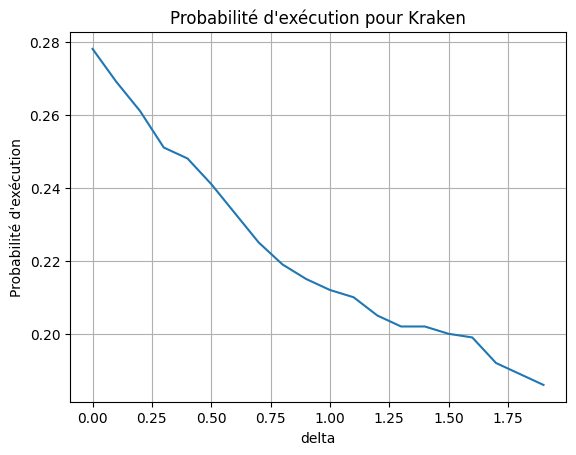

In [21]:
plt.plot(deltas_kraken, probas_fill_kraken)
plt.xlabel('delta')
plt.ylabel("Probabilité d'exécution")
plt.title("Probabilité d'exécution pour Kraken")
plt.grid(True)
plt.show()

In [22]:
nb_deltas = 20

deltas_bitstamp = dict_tick_size['btcusd_bitstamp']*np.arange(0, nb_deltas)
probas_fill_bitstamp = np.zeros(nb_deltas)

for (i, delta) in enumerate(deltas_bitstamp):

    probas_fill_binance[i] = compute_proba_fill(delta=delta, venue='bitstamp')

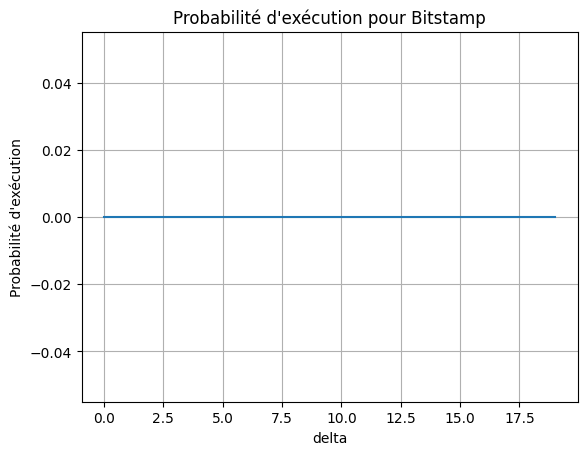

In [23]:
plt.plot(deltas_bitstamp, probas_fill_bitstamp)
plt.xlabel('delta')
plt.ylabel("Probabilité d'exécution")
plt.title("Probabilité d'exécution pour Bitstamp")
plt.grid(True)
plt.show()

On observe que la probabilité d'être exécuté selon l'éloignement $\delta$ dépend fortement des exchanges. Cela se comprend facilement par le fait que les ticks de ces trois venues sont différents. 

- Dans le cas de Binance, dont le tick est le plus faible des trois et vaut 0.01, la fonction prend la forme d'une exponentielle décroissante. 
- Pour Kraken, dont le tick est intermédiaire à 0.1, la fonction prend la forme d'une droite.
- Pour Bitstamp, dont le tick est le plus gros à 1.0, on observe qu'on a du mal à être exécuté et la fonction prend alors la forme d'une droite horizontale.

### b. Etude de la sensibilité selon les états du marché

Construire des variables qui caractérisent l'état du marché au moment du placement (par exemple, l'imbalance au BBO ou le spread bid-ask). Conditionner la probabilité par rapport à chaque état pour faire apparaître des relations. On se restreindra à une 1 dimension: créer des "buckets", par exemple \[-1, -0.5, 0, 0.5, 1\] pour l'imbalance. Commenter les résultats.

On adapte la fonction écrite à la question précédente pour conditionner par rapport à l'état d'imbalance du marché : 

In [24]:
def compute_proba_fill_state(delta: float=0, 
                       N: int=int(1e3), 
                       h: float=10, 
                       duration: int=100, 
                       venue: str='binanceus', 
                       coin: str='btcusd') -> float:
    
    dico_state = {-1: 0, -0.5: 0,
                  0.5: 0, 1: 0}
    dico_fill = {-1: 0, -0.5: 0,
                  0.5: 0, 1: 0}
    
    df_l1 = dict_l1[coin + '_' + venue]
    df_trades = dict_trades[coin + '_' + venue]

    for i in range(N):

        if df_l1.iloc[duration*i].imbalance <= -0.5:
            bucket = -1
        elif df_l1.iloc[duration*i].imbalance <= 0:
            bucket = -0.5
        elif df_l1.iloc[duration*i].imbalance <= 0.5:
            bucket = 0.5
        else:
            bucket = 1
        
        dico_state[bucket] += 1

        price = df_l1.iloc[duration*i].best_bid_price - delta
        ts = df_l1.iloc[duration*i].name

        if (df_trades[(df_trades.index > ts) & (df_trades.index <= ts + h)]['price'] < price).any():

            dico_fill[bucket] += 1

    dico_state_fill = {}

    for key in dico_state:
        if dico_state[key] > 0:
            dico_state_fill[key] = dico_fill[key]/dico_state[key]
    
    return dico_state_fill

In [25]:
nb_deltas = 20

deltas_binance = dict_tick_size['btcusd_binanceus']*np.arange(0, nb_deltas)
probas_fill_binance_0 = np.zeros(nb_deltas)
probas_fill_binance_1 = np.zeros(nb_deltas)
probas_fill_binance_2 = np.zeros(nb_deltas)
probas_fill_binance_3 = np.zeros(nb_deltas)

for (i, delta) in enumerate(deltas_binance):
    
    dico_state_fill = compute_proba_fill_state(delta=delta)
    probas_fill_binance_0[i] = dico_state_fill[-1]
    probas_fill_binance_1[i] = dico_state_fill[-0.5]
    probas_fill_binance_2[i] = dico_state_fill[0.5]
    probas_fill_binance_3[i] = dico_state_fill[1]

In [26]:
nb_deltas = 20

deltas_kraken = dict_tick_size['btcusd_kraken']*np.arange(0, nb_deltas)
probas_fill_kraken_0 = np.zeros(nb_deltas)
probas_fill_kraken_1 = np.zeros(nb_deltas)
probas_fill_kraken_2 = np.zeros(nb_deltas)
probas_fill_kraken_3 = np.zeros(nb_deltas)

for (i, delta) in enumerate(deltas_kraken):
    
    dico_state_fill = compute_proba_fill_state(delta=delta, venue='kraken')
    probas_fill_kraken_0[i] = dico_state_fill[-1]
    probas_fill_kraken_1[i] = dico_state_fill[-0.5]
    probas_fill_kraken_2[i] = dico_state_fill[0.5]
    probas_fill_kraken_3[i] = dico_state_fill[1]

On trace alors la probabilité d'exécution en fonction de l'état du marché : 

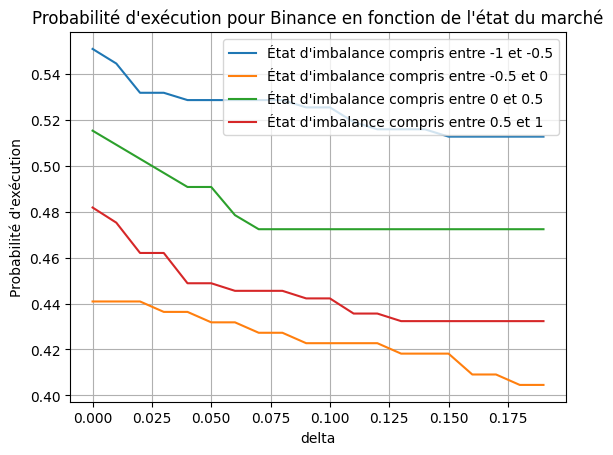

In [27]:
plt.plot(deltas_binance, probas_fill_binance_0, label="État d'imbalance compris entre -1 et -0.5")
plt.plot(deltas_binance, probas_fill_binance_1, label="État d'imbalance compris entre -0.5 et 0")
plt.plot(deltas_binance, probas_fill_binance_2, label="État d'imbalance compris entre 0 et 0.5")
plt.plot(deltas_binance, probas_fill_binance_3, label="État d'imbalance compris entre 0.5 et 1")
plt.xlabel('delta')
plt.ylabel("Probabilité d'exécution")
plt.title("Probabilité d'exécution pour Binance en fonction de l'état du marché")
plt.grid(True)
plt.legend()
plt.show()

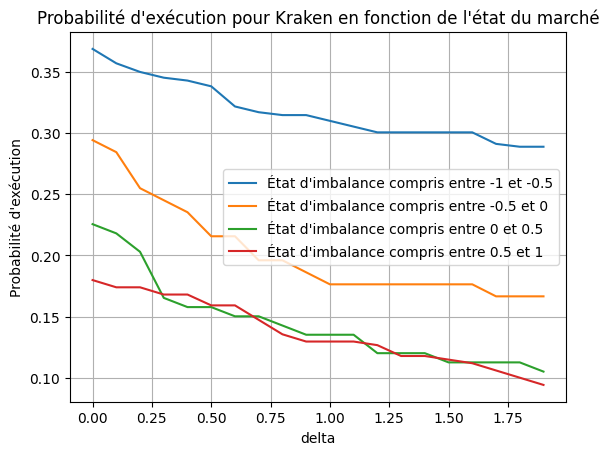

In [28]:
plt.plot(deltas_kraken, probas_fill_kraken_0, label="État d'imbalance compris entre -1 et -0.5")
plt.plot(deltas_kraken, probas_fill_kraken_1, label="État d'imbalance compris entre -0.5 et 0")
plt.plot(deltas_kraken, probas_fill_kraken_2, label="État d'imbalance compris entre 0 et 0.5")
plt.plot(deltas_kraken, probas_fill_kraken_3, label="État d'imbalance compris entre 0.5 et 1")
plt.xlabel('delta')
plt.ylabel("Probabilité d'exécution")
plt.title("Probabilité d'exécution pour Kraken en fonction de l'état du marché")
plt.grid(True)
plt.legend()
plt.show()

On observe que les probabilités d'exécution dépendent de l'état de marché dans lequel on se situe, très naturellement (dans le cas comme ici où on place un ordre à une distance $\delta$ inférieure au mid-price) on s'attend à être plus rapidement exécuté lorsque l'imbalance est comprise entre $-1$ et $-0.5$ que lorsque l'imbalance est comprise entre $0.5$ et $1$. Cela est tout à fait marqué, surtout pour $\textbf{Kraken}$. Cependant, un phénomène particulier apparait pour $\textbf{Binance}$: en effet, lorsque l'imbalance est faiblement négative, la probabilité d'être exécutée est encore plus faible que lorsque l'imbalance est fortement positive. Cela est peut-être dû aux stratégies des markets makers.

## 3. Développement d'une stratégie de trading

##### Cette partie est optionnelle et à réaliser à la maison. Elle sera notée sur 5 et apportera UNIQUEMENT des points bonus pour la note finale.

Développer une stratégie utilisant les deux exercices précédents sur l’un des deux sujets suivants et la tester :

- _Exécution optimale_ : exécution stratégique via Almgren-Chriss puis tactique via les probabilités de premier temps de passage (découper la courbe d’exécution en sous-périodes de 5 secondes par exemple et utiliser un algorithme d’implementation shortfall : choisir entre poster un ordre limite et un ordre marché basé sur la probabilité d’exécution).


- _Market making_ : utiliser une stratégie simple de type Avellaneda-Stoïkov mais y inclure un modèle de probabilité d'exécution et un signal de changement de régime de marché à définir (un jeu de paramètres par régime est souhaitable) ; focus sur la gestion du risque d’inventaire via une estimation précise des probabilités d’exécution.

#### Vous pourrez utiliser la littérature de votre choix et même en extraire des idées. Les citations bibliographiques sont bienvenues pour appuyer votre raisonnement. La performance/robustesse de votre stratégie devra être évaluée en utilisant des données Out-of-Sample! (Estimer les paramètres de votre modèle sur une période et tester la stratégie sur une autre période est obligatoire...)